In [part one](https://jamiemagee.co.uk/2017/09/19/a-survey-of-robots-txt-part-one/) of this article, I collected `robots.txt` from the top 1 million sites on the web. In this article I'm going to do some analysis, and see if there's anything interesting to find from all the files I've collected

First we'll start with some setup

In [40]:
%matplotlib inline

import pandas as pd
import numpy as np
import glob
import os
import matplotlib

Next I'm going to load the content of each file into my pandas dataframe, calculate the file size, and store that for later

In [41]:
l = [filename.split('/')[1] for filename in glob.glob('robots-txt/*')]
df = pd.DataFrame(l, columns=['domain'])
df['content'] = df.apply(lambda x: open('robots-txt/' + x['domain']).read(), axis=1)
df['size'] = df.apply(lambda x: os.path.getsize('robots-txt/' + x['domain']), axis=1)
df.sample(5)

,domain,content,size
100333,bbs.fi,User-agent: *\nAllow: /,23
6767,addicted.org,User-agent: *\nAllow: /\n\n,24
53173,feminan.com,User-agent: *\nDisallow:\n,24
40934,detailer.pl,# robots.txt automaticaly generated by PrestaS...,1627
90340,blogtoplist.com,User-agent: *\nDisallow: /out.php,32


# File sizes

Now that we've done the setup, lets see what the spread of file sizes in `robots.txt` is.

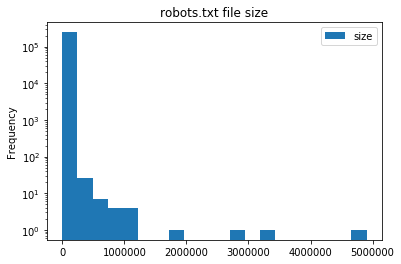

In [42]:
fig = df.plot.hist(title='robots.txt file size', bins=20)
fig.set_yscale('log')

It looks like the majority of `robots.txt` are under 250KB in size. This is really no surprise as `robots.txt` supports regex, so complex rulesets can be built easily.

Let's take a look at the files larger than 1MB. Either they're automatically maintained, some other file masquerading as `robots.txt`, or the site is doing something seriously wrong.

In [43]:
large = df[df['size'] > 10 ** 6].sort_values(by='size', ascending=False)

In [44]:
import re

def count_directives(value, domain):
    content = domain['content']
    return len(re.findall(value, content, re.IGNORECASE))

    
large['disallow'] = large.apply(lambda x: count_directives('Disallow', x), axis=1)
large['user-agent'] = large.apply(lambda x: count_directives('User-agent', x), axis=1)
large['comments'] = large.apply(lambda x: count_directives('#', x), axis=1)
# The directives below are non-standard
large['crawl-delay'] = large.apply(lambda x: count_directives('Crawl-delay', x), axis=1)
large['allow'] = large.apply(lambda x: count_directives('Allow', x), axis=1)
large['sitemap'] = large.apply(lambda x: count_directives('Sitemap', x), axis=1)
large['host'] = large.apply(lambda x: count_directives('Host', x), axis=1)

large

,domain,content,size,disallow,user-agent,comments,crawl-delay,allow,sitemap,host
174777,americanrvcompany.com,Sitemap: http://www.americanrvcompany.com/site...,4904266,56846,1,1,0,56852,2,0
70162,exibart.com,User-Agent: *\nAllow: /\nDisallow: /notizia.as...,3275088,61403,1,0,0,61404,0,0
140458,bigclozet.com,User-agent: *\nDisallow: /item/\n\nUser-agent:...,2708717,51221,4,0,0,51221,0,0
155321,autobaraholka.com,User-Agent: *\nDisallow: /registration/\nDisal...,1749338,39156,1,0,0,39156,0,2
230415,golden-bee.ru,User-agent: Yandex\nDisallow: /*_openstat\nDis...,1139308,24081,4,1,0,24081,0,1
62619,dreamitalive.com,user-agent: google\ndisallow: /memberprofileda...,1116416,34392,3,0,0,34401,0,9
134004,gobankingrates.com,User-agent: *\nDisallow: /wp-admin/\nAllow: /w...,1018685,7366,28,20,2,7367,0,0


It looks like all of these sites are misusing `Disallow` and `Allow`. In fact, looking at the raw files it appears as if they list all of the articles on the site under an individual `Disallow` command. I can only guess that when publishing an article, a corresponding line in `robots.txt` is added.

Now let's take a look at the smallest `robots.txt`

In [45]:
small = df[df['size'] > 0].sort_values(by='size', ascending=True)

small.head(5)

,domain,content,size
133540,friendship-bracelets.net,\n,1
60351,camden.gov.uk,\n,1
60156,docteurtamalou.fr,,1
9473,codedelaroute.io,\n,1
108425,gliphmaker.com,\n,1


There's not really anything interesting here, so let's take a look at some larger files

In [46]:
small = df[df['size'] > 10].sort_values(by='size', ascending=True)

small.head(5)

,domain,content,size
219666,cssf.cz,Disallow: /,11
231535,gestorb.io,Disallow: /,11
48980,elmone.com,Disallow: /,11
87982,adminsolution.org,Disallow: /,11
58520,changning.sh.cn,Disallow: /,11


`Disallow: /` tells all webcrawlers not to crawl anthing on this site, and should (hopefully) keep it out of any search engines, but not all webcrawlers follow `robots.txt`.

# User agents

User agents can be listed in `robots.txt` to either `Allow` or `Disallow` certain paths. Let's take a look at the most common webcrawlers.

In [47]:
from collections import Counter

def find_user_agents(content):
    return re.findall('User-agent:? (.*)', content)

user_agent_list = [find_user_agents(x) for x in df['content']]
user_agent_count = Counter(x.strip() for xs in user_agent_list for x in set(xs))
user_agent_count.most_common(n=10)

[('*', 212330),
 ('Mediapartners-Google', 13551),
 ('Yandex', 9775),
 ('Googlebot', 9532),
 ('MJ12bot', 8079),
 ('Googlebot-Image', 5941),
 ('Baiduspider', 5079),
 ('ia_archiver', 4882),
 ('Slurp', 4092),
 ('Nutch', 4026)]

It's no surprise that the top result is a wildcard (`*`). Google takes spots 2, 4, and 6 with their AdSense, search and image web crawlers respectively. It does seem a little strange to see the AdSense bot lited above the usual search web crawler. Some of the other large search engines' bots are also found in the top 10: Yandex, Baidu, and Yahoo (`Slurp`). `MJ12bot` is a crawler I had not heard of before, but according to [their site](http://mj12bot.com/) it belongs to a UK based SEO company - and according to some of the results about it, it doesn;t behave very well. `ia_archiver` belongs to [The Internet Archive](https://archive.org/), and (I assume) crawls pages for the [Wayback Machine](https://archive.org/web/). Finally there is [Apache Nutch](https://nutch.apache.org/bot.html), and open source webcrawler that can be run by anyone.

# Security by obscurity

There are certain paths that you might not want a webcrawler to know about. For example, a `.git` directory, `htpasswd` files, or parts of a site that are still in testing, and aren't meant to be found by anyone on Google. Let's see if there's anything interesting.

In [48]:
sec_obs = ['\.git', 'alpha', 'beta', 'secret', 'htpasswd', 'install\.php', 'setup\.php']
sec_obs_regex = re.compile('|'.join(sec_obs))

def find_security_by_obscurity(content):
    return sec_obs_regex.findall(content)

sec_obs_list = [find_security_by_obscurity(x) for x in df['content']]
sec_obs_count = Counter(x.strip() for xs in sec_obs_list for x in set(xs))
sec_obs_count.most_common(10)

[('install.php', 10679),
 ('beta', 1162),
 ('alpha', 278),
 ('secret', 232),
 ('.git', 182),
 ('setup.php', 22),
 ('htpasswd', 22)]

Just because a file or directory is mentioned in `robots.txt`, it doesn't mean that it can be accessed anyway. However, if even 1% of Wordpress installs leave their `install.php` open to the world, that's still a lot of vulnerable sites. Any attacker could get the keys to the kingdom very easily. The same goes for a `.git` directory. Even if it is read-only, people accidentally commit secrets to their git repository all the time.

# Conclusion

`robots.txt` is a fairly innocuous part of the web. It's been interesting to see how popular websites (ab)use it, and which web crawlers are naughty or nice. Most of all this has been a great exercise for myself in collecting data an analysing it using Pandas and Jupyter.

The full data set is released under the [Open Database License (ODbL) v1.0](https://opendatacommons.org/licenses/odbl/1.0/) and can be found [on GitHub](https://github.com/JamieMagee/robots-txt)